<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1022transformer_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# `nn.Transformer` と `TorchText` を用いた言語モデル

このファイルは，PyTorch チュートリアルにあったファイルを和訳したものです。

- 原典: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/dca13261bbb4e9809d1a3aa521d22dd7/transformer_tutorial.ipynb

このチュートリアルでは、[nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) モジュールを使ったsequence-to-sequenceモデルの学習を行います。

PyTorch 1.2 のリリースには [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) 論文に基づいた標準的なトランスフォーマーモジュールが含まれています。
リカレントニューラルネットワーク（RNN）と比較して、トランスフォーマーモデルは、多くの seq2seq 課題において，より並列化が可能でありながら， 優れた品質であることが証明されています。
``nn.Transformer`` モジュールは [`nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) として実装されている注意機構に依存して，入出力間の大域的な依存関係を求めることができます。

``nn.Transformer`` モジュールは高度にモジュール化されており、単一の成分 (例えば [`nn.TransformerEncoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)）を簡単に適応／合成することができます。

<img src="https://pytorch.org/tutorials/_images/transformer_architecture.jpg"><br/>


# モデルの定義

このチュートリアルでは，言語モデル課題で ``nn.TransformerEncoder`` モデルを学習します。
言語モデルの課題は， 与えられた単語 (または単語列) が，ある単語の列に続く可能性について確率を割り当てることです。
一連のトークンは，まず埋め込み層に渡され， 続いて単語の順序を考慮した位置符号化層に渡されます (詳細は次段落参照)。
``nn.TransformerEncoder``は、[nn.TransformerEncoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)という複数の層で構成されています。
また，`nn.TransformerEncoder` の **自己注意** 層は， 系列の前の位置にしか注目することができないため， 入力系列とともに， 正方形の注意マスクが必要となります。
言語モデル課題では， 未来の位置にあるトークンはすべてマスクされます。
出力された単語の確率分布を作成するために `nn.TransformerEncoder` モデルの出力は， 線形層を通過させた後，対数ソフトマックス関数を通過させます。




In [ ]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

`PositionalEncoding` モジュールは、系列内のトークンの相対的または絶対的な位置に関する何らかの情報を注入します。
位置符号化器は埋め込み層と同じ次元なので， この 2 つを合計することができます。
ここでは，異なる周波数の `サイン波` と `コサイン波`  関数を使用しています。

---

### (訳注) 
Transformer: Attention is all you need 原著論文中の 位置符号化器は以下のように定義されている:
まず，マルチヘッド自己注意 (MHSA) は，クエリ，キー，バリューベクトルを学習すべきベクトルとして次式で定義される:

$$
\text{MultiHead}\left(Q,K,V\right)=\text{Concat}\left(\mathop{head}_1,\ldots,\mathop{head}_h\right)W^O
$$

ここで，各ヘッドは, $\text{head}_i =\text{Attention}\left(QW_i^Q,KW_i^K,VW_i^V\right)$ である。

それぞれの次元は以下のとおりである:
<!--The projections are parameter matrices-->

- $W_i^Q\in\mathbb{R}^{d_{\mathop{model}}\times d_k}$,
- $W_i^K \in\mathbb{R}^{d_{\mathop{model}}\times d_k}$,
- $W_i^V\in\mathbb{R}^{d_{\mathop{model}}\times d_v}$, 
- $W^O\in\mathbb{R}^{hd_v\times d_{\mathop{model}}}$. $h=8$
- $d_k=d_v=\frac{d_{\mathop{model}}}{h}=64$

$$\text{FFN}(x)=\max\left(0,xW_1+b_1\right)W_2+b_2$$

<!--
$$\text{PE}_{(\mathop{pos},2i)} = \sin\left(\frac{\mathop{pos}}{10000^{\frac{2i}{d_{\mathop{model}}}}}\right)$$

$$\text{PE}_{(\mathop{pos},2i+1)} = \cos\left(\frac{\mathop{pos}}{10000^{\frac{2i}{d_{\mathop{model}}}}}\right)$$
-->

### (続 訳注) 位置符号器 Position encoders
トランスフォーマーの入力には，上述の単語表現に加えて，位置符号器からの信号も重ね合わされる。
位置 $i$ の信号は次式で周波数領域へと変換される:

$$
\begin{align}
\text{PE}_{(\text{pos},2i)} &= \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)\\
\text{PE}_{(\text{pos},2i+1)} &= \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
\end{align}
$$

位置符号器による位置表現は，$i$ 番目の位置情報をワンホット表現するのではなく，周波数領域に変換することで周期情報を表現する試みと見なし得る。




In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

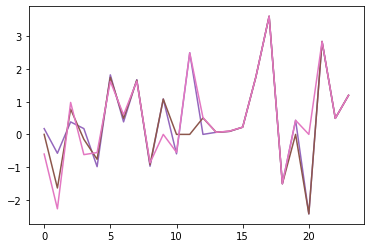

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

PE = PositionalEncoding(d_model=24, max_len=300)

#PE(torch.rand(8))
#print(torch.ones(4))
X = PE(torch.Tensor(np.random.randn(24))).detach().numpy()
plt.plot(range(len(X[0])), X[0])
plt.plot(X[1][0])
plt.plot(X[2][0])
plt.plot(X[3][0])
plt.show()

# データのロードとバッチ化



このチュートリアルでは `torchtext` を用いて Wikitext-2  データセットを生成します。．vocab オブジェクトは訓練データセットに基づいて構築され， トークンをテンソルに数値化するために使用されます。
Wikitext-2 では， 希少なトークンを  `<unk>` として表現します。
1 次元ベクトルの系列データが与えられると， `batch_size` の列にデータを整列させる`batchify()` を行います。
もしデータが `batch_size` の列に均等に分割されないならば，データはフィットするように切り詰められます。
例えば、アルファベットをデータ (全長26) とし， `batch_size=4` とすると，アルファベットを 6 の長さの 4 つの列に分割することになります。

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

バッチングすることで、より並列処理が可能になります。
しかし，バッチ処理を行うと， モデルは各列を独立して扱うことになります。
例えば， 上例では `G` と `F` の依存関係は学習できません。


In [ ]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 20.6MB/s]


## 入力配列とターゲット配列を生成する関数





`get_batch()` は，トランスフォーマモデルの入力とターゲット系列の対を生成します。
ソースデータは長さ `bptt` のチャンクに分割されます。
言語モデル課題では，モデルは次のような単語を `Target` として必要とする。
例えば `bptt` の値が 2 の場合，`i` = 0 の時に以下の 2 つの変数が得られます。
<!-- `get_batch()` generates a pair of input-target sequences for
the transformer model. 
It subdivides the source data into chunks of length `bptt`. 
For the language modeling task, the model needs the following words as `Target`. 
For example, with a `bptt` value of 2, we’d get the following two Variables for `i` = 0: -->

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)

<img src="https://pytorch.org/tutorials/_images/transformer_input_target1.png">

チャンクは 0 次元に沿っており， Transformer モデルの「S」次元と一致していることに留意する必要があります。
バッチ次元「N」は次元 1 に沿っています。





In [ ]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

# インスタンスの初期化


モデルのハイパーパラメータは以下のように定義されています。
語彙サイズは， vocab  オブジェクトの長さに等しい。

In [ ]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

# モデルの実行

[`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) を [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent) オプティマイザと組み合わせて使用しています。
学習率は最初 5.0 に設定され， [`StepLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) のスケジュールに従います。
学習時には [`nn.utils.clip_grad_norm`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) を用いて， 勾配爆発を防ぎます。




In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

エポックをループします。
検証用の損失がこれまで見てきた中で最高であれば、モデルを保存します。
各エポックの後、学習率を調整します。

In [ ]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

# テストデータセットを用いて，最良モデルを評価

In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)